<a href="https://colab.research.google.com/github/rmiller34/atms_597_project4/blob/master/Project_4_Linear_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Linear Model

Import packages

In [0]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pull in files from data processing and mount drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# The following files just have shortened columns, variables have been changed into metric, footers removed
GFS = pd.read_csv('drive/My Drive/ATMS_597_Project_4/GFS_Daily_Tidy.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hr_obs = pd.read_csv('drive/My Drive/ATMS_597_Project_4/CMI_Hourly_Tidy.csv', index_col = 'Timestamp', parse_dates = True)
hr_obs.index = hr_obs.index + pd.DateOffset(hours=12)  

daily_obs = pd.read_csv('drive/My Drive/ATMS_597_Project_4/CMI_Daily_Tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)  



In [0]:
# Merge and drop all days with missing values 
Merge_File = pd.merge(daily_obs.reset_index(), GFS.reset_index(), on = 'Date', how = 'inner')
Merge_File = pd.merge(Merge_File, hr_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')

Merge_File.dropna(inplace = True)  # Remove Nans

In [0]:
Merge_File #Check the file

,Date,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h
0,2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0,-11.26,-16.46,7.323933,0.05,-1.975000,-4.183333,1018.208333,279.166667,6.183333,6.000000,0.000
1,2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0,-10.16,-15.96,4.687217,0.00,-13.325000,-16.933333,1029.316667,286.666667,5.591667,2.250000,0.000
2,2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0,-9.96,-14.36,5.941380,0.06,-16.525000,-19.816667,1032.991667,296.666667,4.633333,0.000000,0.000
3,2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0,-8.46,-12.86,5.685068,0.17,-15.325000,-19.858333,1032.250000,305.833333,3.641667,0.000000,0.000
4,2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0,-7.16,-11.06,3.794733,0.77,-14.441667,-17.700000,1028.141667,290.833333,6.300000,1.333333,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,2019-12-26 12:00:00,16.666667,7.777778,8.04672,0.0,11.84,3.84,4.301163,0.00,10.600000,6.075000,1014.266667,185.000000,5.758333,0.000000,0.000
3609,2019-12-27 12:00:00,6.111111,0.000000,6.70560,0.0,13.94,3.54,8.819297,2.73,13.466667,11.141667,1016.258333,200.833333,6.125000,1.090909,0.000
3610,2019-12-28 12:00:00,13.333333,0.000000,10.28192,0.0,15.94,9.34,9.701546,11.58,2.816667,0.725000,1025.341667,242.500000,2.775000,0.666667,0.000
3611,2019-12-29 12:00:00,15.000000,5.000000,10.28192,6.1,7.24,-1.66,11.111256,2.57,7.141667,6.866667,1018.491667,105.833333,5.975000,9.000000,0.000


In [0]:
Merge_File['day'] = Merge_File['Date'].dt.day
Merge_File['month'] = Merge_File['Date'].dt.month
Merge_File['year'] = Merge_File['Date'].dt.year

In [0]:
#Pull out the variables that are needed
Condense_file = Merge_File.drop(columns =['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)
New_condensed_date_file = Merge_File.drop(columns = ['Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)
Condense_file_list = list(Condense_file.columns)
Merge_File


,Date,Max Hourly Temp (C),Min Hourly Temp (C),Max Wind Speed (m/s),Daily Precip (mm),TMAX,TMIN,WMAX,RTOT,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,day,month,year
0,2010-01-01 12:00:00,-11.111111,-16.666667,6.70560,0.0,-11.26,-16.46,7.323933,0.05,-1.975000,-4.183333,1018.208333,279.166667,6.183333,6.000000,0.000,1,1,2010
1,2010-01-02 12:00:00,-14.444444,-20.555556,6.70560,0.0,-10.16,-15.96,4.687217,0.00,-13.325000,-16.933333,1029.316667,286.666667,5.591667,2.250000,0.000,2,1,2010
2,2010-01-03 12:00:00,-12.222222,-21.111111,4.91744,0.0,-9.96,-14.36,5.941380,0.06,-16.525000,-19.816667,1032.991667,296.666667,4.633333,0.000000,0.000,3,1,2010
3,2010-01-04 12:00:00,-11.666667,-18.888889,8.94080,0.0,-8.46,-12.86,5.685068,0.17,-15.325000,-19.858333,1032.250000,305.833333,3.641667,0.000000,0.000,4,1,2010
4,2010-01-05 12:00:00,-12.222222,-18.333333,7.15264,0.0,-7.16,-11.06,3.794733,0.77,-14.441667,-17.700000,1028.141667,290.833333,6.300000,1.333333,0.000,5,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3608,2019-12-26 12:00:00,16.666667,7.777778,8.04672,0.0,11.84,3.84,4.301163,0.00,10.600000,6.075000,1014.266667,185.000000,5.758333,0.000000,0.000,26,12,2019
3609,2019-12-27 12:00:00,6.111111,0.000000,6.70560,0.0,13.94,3.54,8.819297,2.73,13.466667,11.141667,1016.258333,200.833333,6.125000,1.090909,0.000,27,12,2019
3610,2019-12-28 12:00:00,13.333333,0.000000,10.28192,0.0,15.94,9.34,9.701546,11.58,2.816667,0.725000,1025.341667,242.500000,2.775000,0.666667,0.000,28,12,2019
3611,2019-12-29 12:00:00,15.000000,5.000000,10.28192,6.1,7.24,-1.66,11.111256,2.57,7.141667,6.866667,1018.491667,105.833333,5.975000,9.000000,0.000,29,12,2019


Linear Regression for TMAX

In [0]:
#Linear Regression for TMAX
testing_dates = np.array(New_condensed_date_file.query('year == 2019')['Date'])
training_verification = np.array(Merge_File.query('year < 2019')['Max Hourly Temp (C)'])
testing_verification = np.array(Merge_File.query('year == 2019')['Max Hourly Temp (C)'])


Import sklearn and set up the model for the TMAX regression

In [0]:
# Import and set up the model
from sklearn.linear_model import LinearRegression
lrmax = LinearRegression(fit_intercept=True)

column_names = ['TMAX','TMIN','tmpc'] # Columns for regression
train_vars = Condense_file.query('year < 2019')[column_names] #  training
test_vars = Condense_file.query('year == 2019')[column_names] #  testing

lrmax.fit(train_vars, training_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Predict=lrmax.predict(test_vars) # runs model to get predict for the test period

#print the root mean square error, model slope, and model intercept
#checks the GFS 
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Condense_file.query('year == 2019')['TMAX'].values)), 2), 'degrees C.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Predict)), 2), 'degrees C.')
print("Model slope:    ", lrmax.coef_[0])
print("Model intercept:", lrmax.intercept_)

Baseline Root Mean Square Error: 4.52 degrees C.
Root Mean Square Error: 3.24 degrees C.
Model slope:     0.35495200307720737
Model intercept: 3.9941626236939953


Above print out for TMAX:
 
Baseline Root Mean Square Error: 4.52 degrees C.
Root Mean Square Error: 3.24 degrees C.
Model slope:     0.35495200307720737
Model intercept: 3.9941626236939953

Linear Regression for TMIN

In [0]:
#TMAX
# The following will overrite the above regressions
testing_dates = np.array(New_condensed_date_file.query('year == 2019')['Date'])
training_verification = np.array(Merge_File.query('year < 2019')['Min Hourly Temp (C)'])
testing_verification = np.array(Merge_File.query('year == 2019')['Min Hourly Temp (C)'])


In [0]:
lrmin = LinearRegression(fit_intercept=True)

column_names = ['TMAX','TMIN','tmpc'] # Choose the columns 
train_vars = Condense_file.query('year < 2019')[column_names] #  training
test_vars = Condense_file.query('year == 2019')[column_names] #  testing


lrmin.fit(train_vars, training_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Predict=lrmin.predict(test_vars) # runs model to get predict for the test period

#print the root mean square error, model slope, and model intercept
#checks the GFS forecast 
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Condense_file.query('year == 2019')['TMIN'].values)), 2), 'degrees C.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Predict)), 2), 'degrees C.')
print("Model slope:    ", lrmin.coef_[0])
print("Model intercept:", lrmin.intercept_)

Baseline Root Mean Square Error: 4.25 degrees C.
Root Mean Square Error: 3.1 degrees C.
Model slope:     -0.00885765197046887
Model intercept: -3.5722993297758983


Print out for TMIN: 

Baseline Root Mean Square Error: 4.25 degrees C.
Root Mean Square Error: 3.1 degrees C.
Model slope:     -0.00885765197046887
Model intercept: -3.5722993297758983

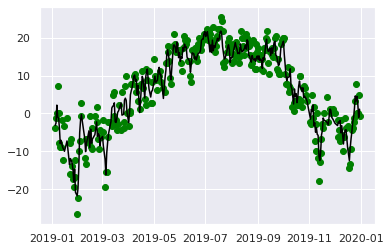

In [0]:
#TMIN
# Make a plot of obs for the test period(dots)  and model predict for the test period  (line)
plt.scatter(testing_dates, testing_verification, c='green')
plt.plot(testing_dates, Predict, c='black')

Linear Regression for Max Wind Speed

In [0]:

# The following will overrite the above regressions
testing_dates = np.array(New_condensed_date_file.query('year == 2019')['Date'])
training_verification = np.array(Merge_File.query('year < 2019')['Max Wind Speed (m/s)'])
testing_verification = np.array(Merge_File.query('year == 2019')['Max Wind Speed (m/s)'])


In [0]:
lrwind = LinearRegression(fit_intercept=True)

column_names = ['WMAX','wspd'] # Choose the columns 
train_vars = Condense_file.query('year < 2019')[column_names] #  training
test_vars = Condense_file.query('year == 2019')[column_names] #  testing


lrwind.fit(train_vars, training_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Predict=lrwind.predict(test_vars) 

#print the root mean square error, model slope, and model intercept
#checks the GFS forecast as base prediction
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Condense_file.query('year == 2019')['WMAX'].values)), 2), 'm/s.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Predict)), 2), 'm/s.')
print("Model slope:    ", lrwind.coef_[0])
print("Model intercept:", lrwind.intercept_)

Baseline Root Mean Square Error: 3.34 m/s.
Root Mean Square Error: 2.62 m/s.
Model slope:     0.47394511541951384
Model intercept: 3.075835480614166


Print out for Max Wind Speed:

Baseline Root Mean Square Error: 3.34 m/s.
Root Mean Square Error: 2.62 m/s.
Model slope:     0.47394511541951384
Model intercept: 3.075835480614166

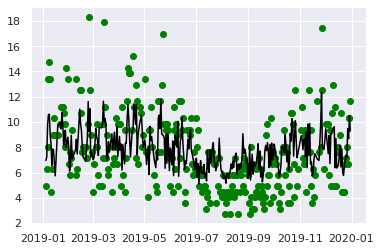

In [0]:
#Max wind speed
# Make a plot of obs for the test period(dots)  and model predict for the test period  (line)
plt.scatter(testing_dates, testing_verification, c='green')
plt.plot(testing_dates, Predict, c='black')

Linear Regression of total precip

In [0]:
#Linear regression total precip
# The following will overrite the above regressions
testing_dates = np.array(New_condensed_date_file.query('year == 2019')['Date'])
training_verification = np.array(Merge_File.query('year < 2019')['Daily Precip (mm)'])
testing_verification = np.array(Merge_File.query('year == 2019')['Daily Precip (mm)'])
#testing_verification

In [0]:
lrprecip = LinearRegression(fit_intercept=True)

column_names = ['RTOT','dwpc','mslp','skct'] # Choose the columns we want to use in the regression!!!
train_vars = Condense_file.query('year < 2019')[column_names] # Get the columns for training
test_vars = Condense_file.query('year == 2019')[column_names] # Get the columns for testing


lrprecip.fit(train_vars, training_verification) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Predict=lrprecip.predict(test_vars) 

#print the root mean square error, model slope, and model intercept
#checks the GFS forecast as base prediction
print('Baseline Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Condense_file.query('year == 2019')['RTOT'].values)), 2), 'mm.')
print('Root Mean Square Error:', round(sqrt(mean_squared_error(testing_verification, Predict)), 2), 'mm.')
print("Model slope:    ", lrprecip.coef_[0])
print("Model intercept:", lrprecip.intercept_)

Baseline Root Mean Square Error: 8.58 mm.
Root Mean Square Error: 4.88 mm.
Model slope:     0.060139244605312586
Model intercept: -5.209994095045092


Print out for Precip:

Baseline Root Mean Square Error: 8.58 mm.
Root Mean Square Error: 4.88 mm.
Model slope:     0.060139244605312586
Model intercept: -5.209994095045092

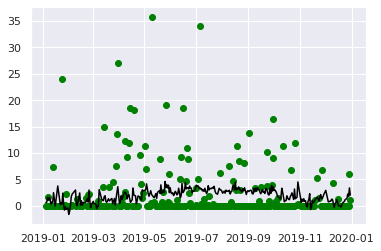

In [0]:
#Precip
plt.scatter(testing_dates, testing_verification, c='green')
plt.plot(testing_dates, Predict, c='black')